In [1]:
import pandas as pd

df = pd.read_csv(f"features_2024.csv")
df['text'] = df['title'] + ' ' + df['abstract']
df["year"] = pd.to_datetime(df["published_date"], errors="coerce").dt.year
df.head(5)

,arxiv_id,title,authors,abstract,published_date,last_revised_date,num_revisions,primary_category,categories,num_pages,...,max_h_index,mean_i10_index,max_i10_index,slope_papers,slope_citations,num_years_after_publication,mean_citations_over_years,std_citations_over_years,text,year
0,1212.2518,Efficient Inference in Large Discrete Domains,"[{'name': 'R Sharma', 'citations_all': None, '...",In this paper we examine the problem of infere...,2012-10-19,2012-10-19T00:00:00,0,13,['cs.AI'],8.0,...,0.0,0.0,0.0,0,0.0,12,0.384615,0.624926,Efficient Inference in Large Discrete Domains ...,2012
1,1212.2511,Stochastic complexity of Bayesian networks,"[{'name': 'K Yamazaki', 'citations_all': 708, ...",Bayesian networks are now being used in enormo...,2012-10-19,2012-10-19T00:00:00,0,35,"['cs.LG', 'stat.ML']",8.0,...,0.0,0.0,0.0,0,0.0,12,1.307692,1.065877,Stochastic complexity of Bayesian networks Bay...,2012
2,1211.5625,A survey of computational methods for protein ...,"[{'name': 'S Srihari', 'citations_all': 3135, ...",Complexes of physically interacting proteins a...,2012-11-24,2012-11-24T00:00:00,0,16,"['cs.CE', 'q-bio.MN']",27.0,...,0.0,0.0,0.0,0,0.0,12,9.307692,5.716166,A survey of computational methods for protein ...,2012
3,1212.2480,Approximate Inference and Constrained Optimiza...,"[{'name': 'T Heskes', 'citations_all': 16337, ...",Loopy and generalized belief propagation are p...,2012-10-19,2012-10-19T00:00:00,0,35,"['cs.LG', 'cs.AI', 'stat.ML']",8.0,...,0.0,0.0,0.0,0,0.0,12,4.384615,1.902972,Approximate Inference and Constrained Optimiza...,2012
4,1212.4674,Natural Language Understanding Based on Semant...,"[{'name': 'H Kong', 'citations_all': None, 'ci...","In this paper, we define event expression over...",2012-12-19,2012-12-19T00:00:00,0,18,['cs.CL'],8.0,...,0.0,0.0,0.0,0,0.0,12,0.000000,0.000000,Natural Language Understanding Based on Semant...,2012


In [2]:
df["arxiv_id"] = df["arxiv_id"].astype(str)
paper_text_df = (
    df.sort_values(["arxiv_id"])
      .assign(text=df["title"] + " " + df["abstract"])
      .groupby("arxiv_id", as_index=False)[["text", "year"]]
      .first()
)

### Train-Test Splitting

In [3]:
TRAIN_END = 2019
TEST_BEGIN = 2020

train_df = paper_text_df[paper_text_df['year'] <= TRAIN_END]
test_df = paper_text_df[paper_text_df['year'] >= TEST_BEGIN]
train_df, test_df

(        arxiv_id                                               text  year
 0      1211.2569  Teichmüller extremal mapping and its applicati...  2012
 1      1211.2575  A semantic cache for enhancing Web services co...  2012
 2      1211.2632  Sequential Voronoi diagram calculations using ...  2012
 3      1211.2636  A memory versus compression ratio trade-off in...  2012
 4       1211.267  A Mazing 2+eps Approximation for Unsplittable ...  2012
 ...          ...                                                ...   ...
 8416  1912.13472  Revisiting Landscape Analysis in Deep Neural N...  2019
 8417  1912.13477  Interaction laws of monads and comonads We int...  2019
 8418   1912.1348  On the Difference Between the Information Bott...  2019
 8419  1912.13487  Winding number for arbitrary integer value in ...  2019
 8420  1912.13497  Water Supply Prediction Based on Initialized A...  2019
 
 [8421 rows x 3 columns],
          arxiv_id                                               text  y

### TF-IDF Encoding

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

train_tfidf = vectorizer.fit_transform(train_df['text'])
test_tfidf = vectorizer.transform(test_df['text'])

In [ ]:
train_tfidf_df = pd.DataFrame(
    train_tfidf.toarray(),                 # shape: (n_samples, 100)
    columns=[f"embedding_{i}" for i in range(train_tfidf.shape[1])],
    index=train_df.index                   # align rows safely
)

test_tfidf_df = pd.DataFrame(
    test_tfidf.toarray(),
    columns=[f"embedding_{i}" for i in range(test_tfidf.shape[1])], 
    index=test_df.index
)

train_tfidf_df = pd.concat((paper_text_df, train_tfidf_df), axis=1, ignore_index=False, join='inner')
test_tfidf_df = pd.concat((paper_text_df, test_tfidf_df), axis=1, ignore_index=False, join='inner')

train_tfidf_df.to_csv("train_tfidf.csv", index=False)
test_tfidf_df.to_csv("test_tfidf.csv", index=False)

### TF-IDF Word Cloud

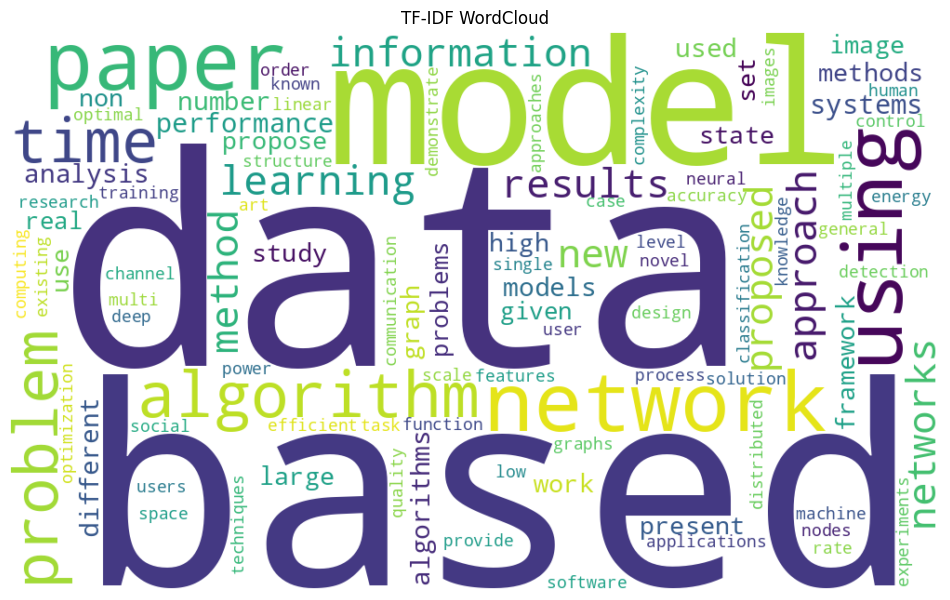

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_matrix = train_tfidf  # sparse matrix

# lấy mean TF-IDF của mỗi từ
tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

# tạo dict: {word: score}
tfidf_dict = {feature_names[i]: tfidf_scores[i] for i in range(len(feature_names))}

wc = WordCloud(width=1000, height=600, background_color="white")
wc.generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF WordCloud")
plt.show()

### BERTopic Embedding

In [ ]:
train_texts = train_df["text"].astype(str).tolist()
test_texts  = test_df["text"].astype(str).tolist()

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# sentence embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True
)

In [ ]:
train_topics, train_probs = topic_model.fit_transform(train_texts)
test_topics, test_probs = topic_model.transform(test_texts)

train_bert_df = train_df.copy()
test_bert_df = test_df.copy()
train_bert_df["topic"] = train_topics
test_bert_df["topic"] = test_topics

In [ ]:
topic_model.get_topic_info().head()

In [ ]:
topics_over_time = topic_model.topics_over_time(train_texts, train_df["year"])

In [ ]:
trend_df = (
    topics_over_time
    .pivot(index="Timestamp", columns="Topic", values="Frequency")
    .fillna(0)
)

trend_df.plot(figsize=(12, 5))

In [ ]:
growth = trend_df.diff().mean().sort_values(ascending=False)
growth.head(10)

In [ ]:
topic_popularity = trend_df.stack().rename("topic_freq").reset_index()

train_bert_df = train_bert_df.merge(
    topic_popularity,
    left_on=["year", "topic"],
    right_on=["Timestamp", "Topic"],
    how="left"
)

test_bert_df = test_bert_df.merge(
    topic_popularity,
    left_on=['year', 'topic'],
    right_on=['Timestamp', 'Topic'], 
    how='left'
)

train_bert_df, test_bert_df

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time)

### LDA Embedding